In [75]:
from dotenv import load_dotenv
load_dotenv()

True

In [76]:
from langchain_groq import ChatGroq

In [77]:
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [78]:
llm.invoke("What is the capital of France?")

AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.053706326, 'prompt_time': 0.000556631, 'queue_time': 0.20206206599999998, 'total_time': 0.054262957}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--183fe1d2-cf7a-499a-be33-1cc7c19ff33d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

In [79]:
from langchain_core.tools import tool

In [80]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [81]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

In [82]:
multiply({"x":2, "y":3})

6

In [83]:
@tool
def search(query: str):
    """search the web for a query and return the results"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return f"Result for {query} is: \n{result}"

In [84]:
print(search.invoke({"query":"What is the capital of France?"}))

Result for What is the capital of France? is: 
[{'title': 'List of capitals of France - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France', 'content': 'This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.\n\n## Chronology\n\n[edit] [...] - Tours (10–13 June 1940), the city served as the temporary capital of France during World War II after the government fled Paris due to the German advance.\n- Bordeaux (June 1940), the government was relocated from Paris to Tours then Bordeaux very briefly during World War II, when it became apparent that Paris would soon fall into German hands. [...] - Paris (1789–1871), on 5 and 6 October 1789, a throng from Paris invaded the castle and forced the royal family to move back to Paris. The National Constituent Assembly "National Constituent Assembly (France)") followed the King to Paris soon afterward; Versailles lost its role of capital city.', 'score': 0.8993

In [85]:
tools = [multiply, search]

In [86]:
tools

[StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002016958E5C0>),
 StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201670EA480>)]

In [87]:
llm_with_tool=llm.bind_tools(tools)

In [88]:
result = llm_with_tool.invoke("What is the current GDP of India?")

In [89]:
result.content

''

In [90]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India'},
  'id': 'pz33mhmfk',
  'type': 'tool_call'}]

In [91]:
result.tool_calls[0]["name"]

'search'

In [92]:
result.tool_calls[0]["args"]

{'query': 'current GDP of India'}

In [93]:
type(result.tool_calls[0]["args"])

dict

In [94]:
tool_mapping={tool.name:tool for tool in tools}

In [95]:
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002016958E5C0>),
 'search': StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201670EA480>)}

In [96]:
tool_mapping["search"]

StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000201670EA480>)

In [97]:
#manually 
# tool_mapping["search"].invoke({"query":"What is the capital of india?"})

In [98]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

'Result for current GDP of India is: \n[{\'title\': \'India Becoming An Economic Powerhouse - PIB\', \'url\': \'https://www.pib.gov.in/PressNoteDetails.aspx?NoteId=154660\', \'content\': \'India’s GDP has witnessed a remarkable transformation over the past decade. At current prices, GDP has increased from ₹106.57 lakh crore in 2014–15 to an estimated ₹331.03 lakh crore in 2024–25, an approximate threefold rise in just ten years. In 2024–25 alone, nominal GDP grew by 9.9% over the previous year, while real GDP (at constant prices) increased by 6.5%, reflecting sustained economic momentum. This steep growth reflects the country’s expanding economic base and rising income levels. [...] India, the world’s fourth-largest economy, has emerged as the fastest-growing major economy and is on track to become the world’s third-largest economy with a projected GDP of $7.3 trillion by 2030. India is projected to be world’s fastest growing major economy (6.3% to 6.8% in 2025-26). This transformation

In [99]:
from typing import TypedDict, Sequence, Annotated

In [100]:
import operator

In [101]:
from langchain_core.messages import BaseMessage

In [102]:
class AgentState(TypedDict):
    """State for the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [103]:
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [104]:
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name

In [105]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

### eariler we were using the tool node from list of tool
### but now we have create tool invoke(custom funtion)
### why we are doing it: as a user if we want to take a authority to which i need to give permission for execution

In [106]:
from langgraph.graph import StateGraph, START,END

In [107]:
graph=StateGraph(AgentState)

In [108]:
graph.add_node("ai_assistant", invoke_model)

In [109]:
graph.add_node("tool", invoke_tool)

In [110]:
graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool", ##with the key tool which value is associated <tool>
                                "end":END
                            }
                            )

In [111]:
graph.add_edge("tool", END)

In [112]:
graph.set_entry_point("ai_assistant")

In [113]:
app=graph.compile()

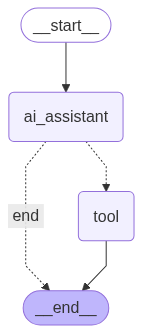

In [114]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [117]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search


{'messages': ['What is the current gdp of the india?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fbpc376fd', 'function': {'arguments': '{"query":"current GDP of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 176, 'total_tokens': 251, 'completion_time': 0.289939576, 'prompt_time': 0.010954767, 'queue_time': 0.20196825799999998, 'total_time': 0.300894343}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d2a58fb1-a74f-4ed1-8ca3-a01f45057a2a-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of India'}, 'id': 'fbpc376fd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 75, 'total_tokens': 251}),
  'Result for current GDP of India is: \n[{\'title\': \'India Becoming An Economic Powerhouse - PIB\', \'url\': \'https://www.pib.gov.in/PressNoteDetails.

In [118]:
app.invoke({"messages":["What is the multiplication of 5 and 20?"]})

Seleted tool: multiply


{'messages': ['What is the multiplication of 5 and 20?',
  AIMessage(content='To multiply 5 and 20, I will use the multiply tool with the provided values.\n\n', additional_kwargs={'tool_calls': [{'id': '65evp0hwz', 'function': {'arguments': '{"x":5,"y":20}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 291, 'prompt_tokens': 177, 'total_tokens': 468, 'completion_time': 1.313980386, 'prompt_time': 0.011072316, 'queue_time': 0.202285102, 'total_time': 1.325052702}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1fbe5db8-531f-421c-bf78-685c92480449-0', tool_calls=[{'name': 'multiply', 'args': {'x': 5, 'y': 20}, 'id': '65evp0hwz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 177, 'output_tokens': 291, 'total_tokens': 468}),
  100]}

### Langgraph inbuilt human in loop


In [119]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools)

In [120]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [121]:
llm_with_tools=llm.bind_tools(tools)

In [122]:
def ai_assistant(state:AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

In [123]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [124]:
graph_builder=StateGraph(AgentState)

In [125]:
graph_builder.add_node("ai_assistant", ai_assistant)

In [126]:
graph_builder.add_node("tools", tool_node)

In [127]:
graph_builder.add_edge(START,"ai_assistant")

In [128]:
graph_builder.add_conditional_edges("ai_assistant",
                                    tools_condition,
                                    )

In [129]:
graph_builder.add_edge("tools", "ai_assistant")

In [130]:
app2=graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])

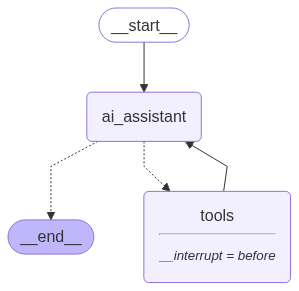

In [131]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [132]:
config={"configurable":{"thread_id":"1"}}

In [140]:
from langchain_core.messages import HumanMessage
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the china?")]},config=config)

In [141]:
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}),
  HumanMessage(content='What is the current gdp of the china?', add

In [142]:
snapshot=app2.get_state(config)

In [143]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}), HumanMessage(content='What is the current gdp of

In [144]:
snapshot.next

('tools',)

In [145]:
last_message=snapshot.values["messages"][-1]

In [146]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gqe41eqnn', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 251, 'prompt_tokens': 248, 'total_tokens': 499, 'completion_time': 1.047800742, 'prompt_time': 0.016112438, 'queue_time': 0.202006786, 'total_time': 1.06391318}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--06aa4a62-f984-4e44-a50d-bb53d22195ad-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'gqe41eqnn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 248, 'output_tokens': 251, 'total_tokens': 499})

In [147]:
tool_details=last_message.tool_calls

In [148]:
tool_details

[{'name': 'search',
  'args': {'query': 'current GDP of China'},
  'id': 'gqe41eqnn',
  'type': 'tool_call'}]

In [149]:
tool_details[0]["name"]

'search'

In [150]:
if tool_details[0]["name"]== "search":
    user_input=input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}?").lower()
    if user_input=="no":
        print("web tool discarded")
        raise Exception("Web tool discarded by the user.")
    else:
        response=app2.invoke(None,config)
        print(response)
else:
    response=app2.invoke(None,config)
    print(response)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}), HumanMessage(content='What is the current gdp of the china?', additio

In [151]:
app2.invoke(None,config) #none means resume the last state or resume the process

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}),
  HumanMessage(content='What is the current gdp of the china?', add

In [152]:
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

In [154]:
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}),
  HumanMessage(content='What is the current gdp of the china?', add

In [157]:
snapshot=app2.get_state(config)

In [158]:
snapshot.next

('tools',)

In [159]:
last_message=snapshot.values["messages"][-1]

In [160]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of Japan'},
  'id': '9x5xhahmg',
  'type': 'tool_call'}]

In [161]:
tool_call_id=last_message.tool_calls[0]["id"]

In [162]:
tool_call_id

'9x5xhahmg'

In [153]:
from langchain_core.messages import AIMessage,ToolMessage

In [163]:
new_message=[
    ToolMessage(content="according to the latest data 4.1 trillion USD",tool_call_id=tool_call_id),
    AIMessage(content="GDP is 4.1 Trillion USD.")
    
]

In [164]:
app2.update_state(config, 
                  {
                      "messages":new_message
                   }
                  )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06a58e-416f-6bd1-800a-2a5ce628678b'}}

In [165]:
app2.get_state(config).values["messages"][-1]

AIMessage(content='GDP is 4.1 Trillion USD.', additional_kwargs={}, response_metadata={})

In [166]:
app2.invoke(None,config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}),
  HumanMessage(content='What is the current gdp of the china?', add

In [168]:
app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have access to real-time data, including the current GDP of China. For the most accurate and up-to-date information, I recommend checking a reliable source like the World Bank, IMF, or official Chinese economic reports. Let me know if you'd like help finding a specific source!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 176, 'total_tokens': 319, 'completion_time': 0.590518117, 'prompt_time': 0.010951665, 'queue_time': 0.202081989, 'total_time': 0.601469782}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa6f9a78-843e-4cc8-83c1-a7650b837f0e-0', usage_metadata={'input_tokens': 176, 'output_tokens': 143, 'total_tokens': 319}),
  HumanMessage(content='What is the current gdp of the china?', add